# Description of the game

Let us describe this game of flipping an unfair coin.
Let $p_h$ be the probability of getting a head of flipping this coin.
Assume that this quantity is known to the agent.
For each round of the game, the agent can take the action of betting $a$ dollars, where $a$ is an integer, less than or equal to the capital $s$ that the agent has.
The agent will gain $a$ dollars if the result of the coin toss is a head, else loses all the amount they bet.
The goal of the agent is to get a capital of $n$ dollars, at which point the game ends.
The game also ends if the agent loses all their capital.

# Problem setup

1.   Compute the state-value function given a policy.
2.   Find the optimal policy of the agent given a starting capital $>0$ and compute the probability of reaching their goal of getting $n$ dollars.

# Markov Decision Process

This problem can be viewed via the lense of Markov Decision Process.

## State, action and reward
*   States - capital - $S=\{0,1,2,\cdots,n\}$.
*   Actions - bet size - $A_s= \{1,\cdots , min(s,n-s)\}$.
*   Rewards - $r\in\mathbb{R}^{n+1}$, with index set $\{0,\cdots,n\}$, such that
$$r_s=
\begin{cases}
1 &\text{if} &s=n;\\
0 &\text{otherwise.}
\end{cases}$$

## Dynamics
Clearly, the capital that the agent posesses after a coin flip only depends on the present capital and the bet size, but not the history of capital owed by the agent.
Thus, this is a Markov process.

Since $r(s=n)=1$, we'd better transit the state $s=n$ to another absorbing state with reward $=0$, in this case, this can be $s=0$.
Let's deal with the special cases first:
$$
  p(0|0)=p(0|n)=1.
$$
For the transient states,
$$
  p(s'|s,a)=
  \begin{cases}
  p_h &\text{if} &s' = s+a;\\
  1-p_h &\text{elif} &s'= s-a;\\
  0 &\text{otherwise}.
  \end{cases}
$$

[comment]: <> (This is a comment, it will not be included)
[comment]: <> (in  the output file unless you use it in)
[comment]: <> (a reference style link.)

[comment]: <> (The transition matrix $P$ is given by)
[comment]: <> ($P_{s,s'}= p(s'|s,\pi(s))$.)
[comment]: <> ($$)
[comment]: <> (  P_{0,*}=P_{100,*} =)  
[comment]: <> (  \begin{bmatrix})
[comment]: <> (    1 & 0 & \cdots & 0)  
[comment]: <> (  \end{bmatrix}.)
[comment]: <> ($$)
[comment]: <> (If $0 < s < 100$,)
[comment]: <> ($$)
[comment]: <> (P_{s,s'}=)
[comment]: <> (\begin{cases})
[comment]: <> (1-p_h&\text{if} &s'=s-\pi(s)\\)
[comment]: <> (p_h&\text{elif} &s'=s+\pi(s)\\)
[comment]: <> (0&\text{otherwise.})
[comment]: <> (\end{cases})
[comment]: <> ($$)


# Computing the state-value function

## State-value function

Recall the definition of a policy.
Let


*   $S$ be the set of possible states;
*   $A$ be the set of possible actions;
*   $\{A_s\}_{s\in S}$ be a family of subsets of $A$ - where $A_s$ is the set of possible actions available to the agent at state $s$.

A policy is a map $\pi: S→A$, where $\pi(s)\in A_s$ for all $s\in S$.

Recall the definition of the state-value function given a policy $\pi$.
Let

*   $\gamma\in [0,1]$ be the discount factor that discounts future reward.
*   $R_t$ be the reward gained at the $t$-th timestep
*   $G_t:=\sum_{i=0}^{\infty} \gamma^{i}R_{t+i}$ be **total** discounted reward gained after timestep $t$.

Then the state-value function $$v^{\pi}(s) := \mathbb{E}_{\pi}[G_t|S_t=s]$$ is defined as total expected reward over time given state $s$, where action at each timestep is taken according to the policy $\pi$.

## State-value function (closed form)
Note that $G_t = R_t + \gamma G_{t+1}$.
After taking expectation, we have the Bellman equation:
$$
v^{\pi}(s) = r(s) + \gamma \sum_{s'\in S}p(s'|s,\pi(s))v^{\pi}(s').
$$
Let $P^{\pi}$ be the transition matrix under the policy $\pi$, i.e.,
$$P^{\pi}_{s,s'} = p(s'|s, \pi(s)).$$

Then the Bellman equation takes the following matrix form,
\begin{align*}
v^{\pi}&= r + \gamma P^{\pi} v^{\pi}.\\
(I-\gamma P^{\pi})v^{\pi}&=r.
\end{align*}
To solve for $v^{\pi}$, we want to invert the matrix $(I-\gamma P^{\pi})$.

**The matrix $(I-\gamma P^{\pi})$ is invertible if and only if the discount factor $\gamma < 1$**:

(Proof) Since the total of transition probability from a state $s$ to all other states must be 1, sum of each row of $P^{\pi}$ is $1$, i.e.,
$$
P^{\pi}
\begin{bmatrix}
1 \\
1 \\
\vdots \\
1
\end{bmatrix}
=
\begin{bmatrix}
1 \\
1 \\
\vdots \\
1.
\end{bmatrix}
$$
Thus, the vector
$\begin{bmatrix}
1 \\
1 \\
\vdots \\
1
\end{bmatrix}$ lies in the kernel of $(I-P^{\pi})$.

Say $x$ is an eigenvector of $P^{\pi}$ with eigenvalue $\lambda=\frac{1}{\gamma} > 1$.
Then each component of $P^{\pi}x$ is a convex combination of components of $x$.
Without loss of generality, assume $x_{max} > 0$ (consider $x_{min}$ otherwise).
Then each component of $P^{\pi}x$ is bounded above by $x_{max}$, but there is some component of $\lambda x$ greater than $x_{max}$.
(I learned this argument from this stackexchange [post](https://math.stackexchange.com/questions/40320/proof-that-the-largest-eigenvalue-of-a-stochastic-matrix-is-1)) $\blacksquare$

The above argument demostrates why it is often convenient to choose a discount factor $\gamma < 1$.


## State-value function (closed form) implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def state_value_closed(policy, r, head_prob, gamma):

    # transition matrix under policy P^{\pi}
    P = [[0 for _ in range(len(policy))] for _ in range(len(policy))]
    for s in range(1,len(policy)-1):
        P[s][s-policy[s]]=(1-head_prob)
        P[s][s+policy[s]]=head_prob
    P[0][0]=1
    P[-1][0]=1
    P = np.asarray(P)

    v = np.matmul(np.linalg.inv(np.identity(len(policy))-gamma*P),r)
    return v

In [3]:
n = 100
policy = [1]*(n+1)
r = [1 if i==n else 0 for i in range(n+1)]
head_prob = 0.4
gamma = 0.99

In [4]:
v = state_value_closed(policy, r, head_prob, gamma)

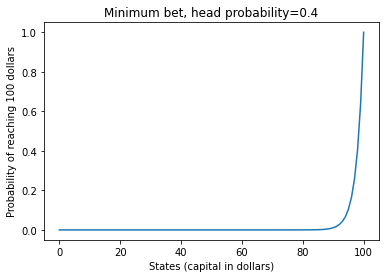

In [5]:
plt.title(f"Minimum bet, head probability={head_prob}")
plt.xlabel('States (capital in dollars)')
plt.ylabel(f'Probability of reaching {n} dollars')
plt.plot(v)
plt.show()

Inverting the matrix seems a bad idea due to numerical instability - the first few terms of the computed state-value function are negative.

In [6]:
v

array([-1.12143740e-16, -1.56204396e-16, -1.14096195e-16, -8.01688903e-17,
       -1.04334048e-16, -1.03876868e-16, -9.87774823e-17, -8.82054324e-17,
       -1.13009568e-16, -1.08624131e-16, -1.01181012e-16, -8.91605868e-17,
       -1.02624859e-16, -9.11527982e-17, -7.30710167e-17, -4.46447102e-17,
       -2.25174185e-17, -3.03068438e-19,  3.45691859e-17,  8.93070808e-17,
        1.56470167e-16,  2.80643215e-16,  4.75544088e-16,  7.81458187e-16,
        1.25932027e-15,  2.01166322e-15,  3.19253104e-15,  5.04600599e-15,
        7.95437255e-15,  1.25201316e-14,  1.96864888e-14,  3.09347119e-14,
        4.85661098e-14,  7.62462755e-14,  1.19692712e-13,  1.87885687e-13,
        2.94908774e-13,  4.62902592e-13,  7.26583556e-13,  1.14045385e-12,
        1.79004738e-12,  2.80965317e-12,  4.41001346e-12,  6.92191865e-12,
        1.08645651e-11,  1.70529009e-11,  2.67660343e-11,  4.20116363e-11,
        6.59409397e-11,  1.03500070e-10,  1.62452405e-10,  2.54983240e-10,
        4.00218464e-10,  

## Iterative policy evaluation

If we let
$$v^{\pi}_{k}(s) = \mathbb{E}_{\pi}[\sum^{k-1}_{i=0}\gamma^i r_{t+i}|S_t=s],$$
then clearly $v^{\pi}_{k}→ v^{\pi}$ as $k→\infty$.



Moreover, the Bellman equation takes the form:
$$v^{\pi}_{k}(s) = r(s) + \gamma \sum_{s'\in S}p(s'|s,\pi(s))v^{\pi}_{k-1}(s'),$$
which gives an iterative way of computing the sequence $\{v^{\pi}_{k}\}_{k\geq 1}$.
It was suggested that we terminate the computation if $||v^{\pi}_{k}-v^{\pi}_{k-1}||_{\infty}$ is small.

In [12]:
def policy_eval(policy, head_prob, r, gamma, threshold, print_iter=False):
    # initialize v
    v = np.zeros(len(policy))
    # transition matrix P under policy
    P = [[0 for _ in range(len(policy))] for _ in range(len(policy))]
    for s in range(1,len(policy)-1):
        P[s][s-policy[s]]=(1-head_prob)
        P[s][s+policy[s]]=head_prob
    P[0][0]=1
    P[-1][0]=1
    P = np.asarray(P)
    n_iter = 0
    while True:
        new_v = r + gamma*np.matmul(P,v)
        n_iter += 1
        if max(new_v-v)<threshold:
            if print_iter:
                print(f"Number of iterations: {n_iter}")
            return new_v
        v = new_v

In [17]:
n = 100
policy = [1]*(n+1)
r = [1 if i==n else 0 for i in range(n+1)]
head_prob = 0.4
gamma = 0.99
threshold = 1e-10
v = policy_eval(policy, head_prob, r, gamma, threshold)

No negative terms in the beginning. We shall be using the iterative policy evaluation.

In [14]:
v

array([0.00000000e+00, 1.34431528e-20, 3.39473555e-20, 6.61252859e-20,
       1.16062012e-19, 1.95713258e-19, 3.20132381e-19, 5.19406546e-19,
       8.31434119e-19, 1.33100923e-18, 2.11398323e-18, 3.36526124e-18,
       5.32715961e-18, 8.45554176e-18, 1.33616388e-17, 2.11676413e-17,
       3.34111816e-17, 5.28523044e-17, 8.33486427e-17, 1.31685044e-16,
       2.07515026e-16, 3.27512660e-16, 5.15779634e-16, 8.13288665e-16,
       1.28008980e-15, 2.01686550e-15, 3.17295998e-15, 4.99580658e-15,
       7.85623321e-15, 1.23624247e-14, 1.94338943e-14, 3.05658560e-14,
       4.80356636e-14, 7.55201226e-14, 1.18653885e-13, 1.86480527e-13,
       2.92929594e-13, 4.60250048e-13, 7.22853204e-13, 1.13548770e-12,
       1.78311338e-12, 2.80047842e-12, 4.39724513e-12, 6.90511618e-12,
       1.08412944e-11, 1.70224403e-11, 2.67240188e-11, 4.19569324e-11,
       6.58658212e-11, 1.03402768e-10, 1.62319370e-10, 2.54811809e-10,
       3.99985109e-10, 6.27878690e-10, 9.85574584e-10, 1.54706472e-09,
      

### (Aside) Error analysis
More precisely,
$$
||v^{\pi}_{k} - v^{\pi}||_{\infty}\leq \frac{\gamma^{k}}{1-\gamma}||r||_{\infty}.
$$
Say we want to bound the error by $\epsilon$.
Then solving $\frac{\gamma^{k}}{1-\gamma}||r||_{\infty}\leq \epsilon$, we get
$k\geq \frac{\log(\epsilon (1-\gamma))-\log(||r||_{\infty})}{
  \log\gamma}$.
The number of iterations $k$, is quite sensitive to $1-\gamma$:
letting $N=\frac{1}{1-\gamma}$, then $\frac{\log(1-\gamma)}{\log \gamma}\sim N\log N$. Thus, we want to be careful with the discount factor if we want to get an accurate approximation of the state-value function.

# Optimal policy search

We will cover two policy search algorithms here.

## Policy iteration

Define a policy $\pi_*$ to be *optimal* if the corresponding state-value function $v^{\pi_*}$ is optimal, i.e.
for any policy $\pi$, not all components of $v^{\pi}$ are greater than $v^{\pi_*}$.
While there may be more than one optimal policy, an optimal state-value function is unique. For a proof, see the section below on Value Iteration.

Recall the definition of an action-value function $q^{\pi}(s,a)$ under a given policy $\pi$.
It is the total expected reward, where the agent will take the action $a\in A_s$ in the current timestep and will follow the policy $\pi$ afterwards:
$$q^{\pi}(s,a):=\mathbb{E}_{\pi}[G_t|S_t=s, A_t = a].$$

If we let the *policy improvement* $\pi'(s):=\arg \max_{a\in A_s}q^{\pi}(s,a)$.
Then $q^{\pi}(s, \pi')\geq v^{\pi}(s)$.
In fact, iteratively plugging in the above inequality into the right hand side of the following Bellman equation for $q^{\pi}$:
$$q^{\pi}(s, \pi'(s))=r(s)+\sum_{s'}p(s'|s, \pi'(s))v^{\pi}(s'),$$
one can show that
$$v^{\pi}(s)\leq q^{\pi}(s,\pi'(s))\leq v^{\pi'}(s).$$
If $\pi = \pi'$, then the above inequalities are equalities.
We then have
$$
v^{\pi}(s) = \max_{a\in A_s} \big(r(s)+\sum_{s'}p(s'|s, a)v^{\pi}(s')\big),
$$
which means $v^{\pi}$ is optimal (c.f. the section "Uniqueness of optimal state-value function").
This suggests the following policy iteration algorithm:

```
Initialize policy

while True:
    v ← policy_eval(policy)
    old_policy ← policy
    policy[s] ← arg max_a q^{old_policy}(s,a)
    if policy == old_policy:
        return policy, v
```

Since there are only finitely many policies, this iterative process must terminate.

## Policy iteration implementation

In [7]:
def policy_init(n):
    """
    Randomly initialize policy
    """
    lo = [1]*(n+1)
    hi = [min(i,n-i)+1 for i in range(n+1)]
    hi[0] = hi[-1] = 2
    policy_float = np.random.uniform(lo, hi)
    policy = policy_float.astype(int)
    return policy

In [8]:
def get_dynamics(n, head_prob):
    """
    Get a 3-d tensor P_{a,s,s'} = p(s'|s,a)
    """
    P = [[[0 for s1 in range(n+1)] for s in range(n+1)] for a in range(n//2)]
    for s in range(1,n):
        for a in range(min(s, n-s)):
            P[a][s][s-(a+1)] = (1-head_prob)
            P[a][s][s+a+1] = head_prob
    P[0][0][0]=1
    P[0][-1][0]=1
    P = np.asarray(P)
    return P

In [6]:
def get_policy_dynamics(policy, head_prob):
    """
    Get a transition matrix P with P_{s,s'} = p(s'|s, policy[s])
    """
    P = [[0 for _ in range(len(policy))] for _ in range(len(policy))]
    for s in range(1,len(policy)-1):
        P[s][s-policy[s]]=(1-head_prob)
        P[s][s+policy[s]]=head_prob
    P[0][0]=1
    P[-1][0]=1

In [9]:
def policy_improve(P, v, r):
    q = np.matmul(P, v)+r
    return np.argmax(q, axis =0)+1

In [48]:
 def policy_iteration(head_prob, r, gamma, threshold, print_iter=False):
    
    n = len(r) - 1
    policy = policy_init(n)
    # 3d-tensor P_{a,s,s'} = p(s'|s,a)
    P = get_dynamics(n, head_prob)
    n_iter = 0
    v_history = []
    while True:
        v = policy_eval(policy, head_prob, r, gamma, threshold)
        v_history.append(v)
        new_policy = policy_improve(P, v, r)
        n_iter += 1
        if np.array_equal(new_policy, policy):
            v_history = np.asarray(v_history)
            if print_iter:
                print(f"Number of iterations: {n_iter}")
            return policy, v_history
        policy = new_policy

In [96]:
n = 200 #@param {type:"slider", min:1, max:500, step:1}
head_prob = 0.4 #@param {type:"slider", min:0, max:1, step:0.01}
gamma = 0.99 #@param {type:"number"}
threshold = 1e-10 #@param {type:"number"}
r = np.zeros(n+1)
r[-1] = 1

In [100]:
start_time = time.time()
policy_p, v_history_p = policy_iteration(head_prob, r, gamma, threshold, print_iter=True)
print("--- %s seconds ---" % (time.time() - start_time))

Number of iterations: 8
--- 1.7619318962097168 seconds ---


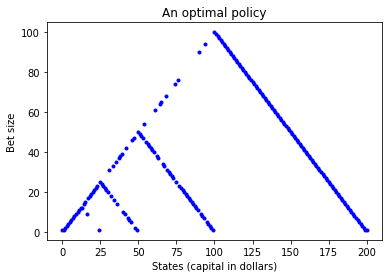

In [101]:
plt.title("An optimal policy")
plt.ylabel('Bet size')
plt.xlabel('States (capital in dollars)')
plt.plot(policy, 'b.')
plt.show()

The state-value function converges to the optimal one fairly quickly.

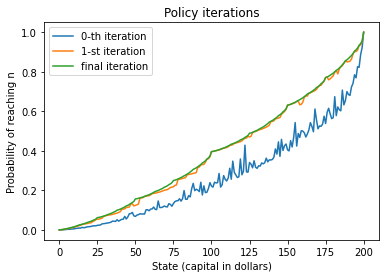

In [102]:
plt.title('Policy iterations')
plt.xlabel('State (capital in dollars)')
plt.ylabel('Probability of reaching n')
plt.plot(v_history_p[0], label=f"{0}-th iteration")
plt.plot(v_history_p[1], label=f"{1}-st iteration")
plt.plot(v_history_p[-1], label="final iteration")
plt.legend()
plt.show()

## Uniqueness of optimal state-value function

In this section, we shall prove the uniqueness of the optimal state-value function and is given by the unique fixed point of the Bellman operator.

### Bellman operator

The state-value function of the optimal policy satisfies the following equation (in $v$)
$$
v(s) = \max_{a\in A(s)}\big(r(s) + \gamma\sum_{s'}p(s'|s,a)\cdot v(s')\big),
$$
which determines the policy by setting
$$
\pi(s) := \arg \max_{a\in A(s)}\big(r(s) + \gamma\sum_{s'}p(s'|s,a)\cdot v(s')\big).
$$

This suggests we can cast the problem of computing the state-value function as a math problem: finding the fix point of the *Bellman operator*
\begin{align}
B: \mathbb{R}^{|S|}&→\mathbb{R}^{|S|}\\
v&\mapsto \big(\max_{a\in A(s)}(r(s) + \gamma\sum_{s'}p(s'|s,a)\cdot v(s'))\big)_{s\in S}.\\
\end{align}
We shall show in the next section that $B$ admits a unique fixed point.
Since the state-value function of an optimal policy gives rise to a fixed point of $B$, the state-value function of an optimal policy is unique.

### Existence and Uniqueness of the fixed point

The state-value function $v^{\pi}(s)$ of an optimal policy $\pi$ is clearly a fixed point of $B$. This proves existence.

We claim that
\begin{equation}
||B(v)-B(v')||_{\infty}\leq \gamma ||v-v'||_{\infty}
\end{equation}
for any $v, v'\in \mathbb{R}^{|S|}$.

Indeed,
\begin{align*}
||B(v)-B(v')||_{\infty} &= \max_s |\max_{a\in A(s)}\big(r(s) + \gamma\sum_{s'}p(s'|s,a)\cdot v(s')\big)-\max_{a\in A(s)}\big(r(s) + \gamma\sum_{s'}p(s'|s,a)\cdot v'(s')\big)|\\
&\leq \max_s |\max_{a\in A(s)}\gamma\sum_{s'}p(s'|s,a)\cdot (v(s')-v'(s'))|\\
&\leq \max_s \max_{a\in A(s)}\gamma\sum_{s'}p(s'|s,a)\cdot ||v-v'||_{\infty}\\
&\leq \gamma ||v-v'||_{\infty}\\
\end{align*}

Now let $v_1, v_2\in \mathbb{R}^{|S|}$ be two fixed points of $B$.
Then
$$
||B(v_1)- B(v_2)||_{\infty}
\leq
\gamma||v_1- v_2||_{\infty}.
$$
But $v_1, v_2$ are fixed points of $B$ by hypothesis,
$||B(v_1)- B(v_2)||_{\infty}= ||v_1- v_2||_{\infty}$.
This forces $v_1=v_2$. $\blacksquare$



## Value iteration

Let $v_0$ be the fixed point of the Bellman operator $B$.
We claim that for any point $v\in \mathbb{R}^{|S|}$,
the sequence $\{B^{k}(v)\}_{k\geq 1}$ converges to $v_0$.
Indeed,
$$||B^{k}(v) - v_0||_{\infty}=||B^{k}(v) - B^{k}(v_0)||_{\infty}\leq \gamma^{k}||v-v_0||_{\infty},$$
where the last term goes to zero as $k\rightarrow \infty$.

The value iteration algorithm is nothing but repeatedly applying $B$ until convergence.

## Value iteration implementation

In [79]:
def value_iter(head_prob, r, gamma, threshold, print_iter=False):
    v = np.zeros(len(r))
    P = get_dynamics(len(r)-1, head_prob)
    v_history = [v]
    n_iter = 0
    while True:
        new_v = np.max(gamma*np.matmul(P,v) + r, axis=0)
        v_history.append(new_v)
        n_iter += 1
        if np.max(np.abs(new_v - v)) < threshold:
            if print_iter:
                print(f"Number of iterations: {n_iter}")
            policy = np.argmax(gamma*np.matmul(P,v) + r, axis=0) + 1
            v_history = np.asarray(v_history)
            return policy, v_history
        v = new_v

In [74]:
n = 400 #@param {type:"slider", min:1, max:500, step:1}
head_prob = 0.4 #@param {type:"slider", min:0, max:1, step:0.01}
gamma = 0.99 #@param {type:"number"}
threshold = 1e-10 #@param {type:"number"}
r = np.zeros(n+1)
r[-1] = 1

In [110]:
start_time = time.time()
policy_v, v_history_v = value_iter(head_prob, r, gamma, threshold, print_iter=True)
print("--- %s seconds ---" % (time.time() - start_time))

Number of iterations: 35
--- 0.7768881320953369 seconds ---


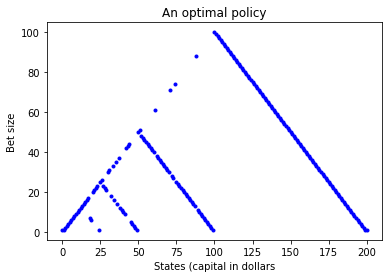

In [113]:
plt.title("An optimal policy")
plt.ylabel('Bet size')
plt.xlabel('States (capital in dollars')
plt.plot(policy_v, 'b.')
plt.show()

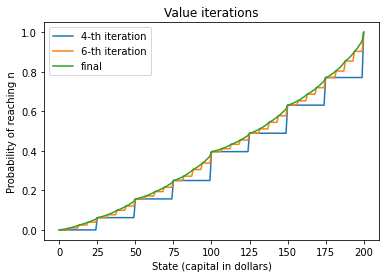

In [114]:
plt.title('Value iterations')
plt.xlabel('State (capital in dollars)')
plt.ylabel('Probability of reaching n')
plt.plot(v_history_v[len(v_history_v)//8], label=f"{len(v_history_v)//8}-th iteration")
plt.plot(v_history_v[len(v_history_v)//6], label=f"{len(v_history_v)//6}-th iteration")
plt.plot(v_history_v[-1], label="final")
plt.legend()
plt.show()

## Conclusions

### Time complexity and potential pitfall

The policy evaluation step in the policy iteration is computationally expensive - itself requiring hundreds of iterations to compute the state-value function. On the other hand, we see empirically that the value iteration algorithm requires more iterations, while each iteration is a lot cheaper than the policy iteration algorithm. The policy iteration algorithm is perhaps not very robust.
When there are more than one optimal policies, the algorithm may oscillate among the optimal policies, causing the algorithm to not terminate. An obvious way to fix this is to cache all policies that were considered and terminate once a policy is revisited.

### More than one optimal policies

If one has to guess what the optimal policy is, given that the probability of head is $< 0.5$, a reasonable guess would be to take the maximum bet size allowed. The intuition here is that the expected value of the capital deteriorates over time. Let us compute the state-value function of this policy and compare it with the results of the policy iteration and value iteration. 

In [103]:
test_policy = [1 for _ in range(n+1)]
for i in range(1, n//2 +1):
    test_policy[i] = i
for i in range(n//2 +1, n):
    test_policy[i] = n - i

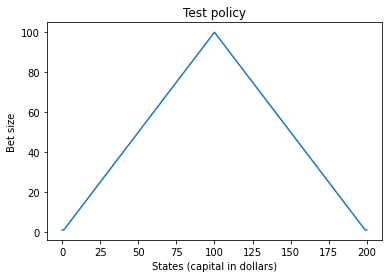

In [108]:
plt.title('Test policy')
plt.xlabel('States (capital in dollars)')
plt.ylabel('Bet size')
plt.plot(test_policy)
plt.show()

In [106]:
test_v = policy_eval(test_policy, head_prob, r, gamma, threshold)

The state-value function of these 3 different policies are pretty much the same, suggesting they are all optimal policies.

In [120]:
np.max(np.abs(test_v-v_history_v[-1]))

1.1102230246251565e-16

In [121]:
np.max(np.abs(test_v-v_history_p[-1]))

1.1102230246251565e-16